# Лабораторная работа №2 (курс "Математические методы анализа текстов")

#### Тема: Определение частей речи и выделение именованных сущностей.


**Выдана**:   15 марта 2018

**Дедлайн**:   <font color='red'>21:00 29 марта 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 2.7)

#### Правила:

Результат выполнения задания - отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев - тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 2.7). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение преподавателей в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе необходимо:

- обучить скрытую марковскую модель на размеченных данных и реализовать алгоритм Витерби для задачи POS-теггинга (определение частей речи слов в тексте)

- научиться использовать ряд POS-теггеров из библиотеки NLTK и сравнить качество их работы

- придумать различные признаки для CRF и использовать их в реализации CRF из пакета CRFsuite для решения задачи NER (выделение именованных сущностей в тексте)

- использовать готовое решение для решения задачи NER и сравнить качество

#### Комментарии и советы:

1. Для выполнения потребуются модули Python numpy, nltk, pycrfsuite (для импорта последнего нужно установить пакет python-crfsuite).

2. Все необходимые для выполнения задания данные либо приложены, либо могут быть скачаны с помощью nltk.download().

3. Посмотреть параметры конструктора и других методов классов можно набрав и выполнив в ячейке с кодом '?full_method_name'.

4. В коде Stanford NER tagger, возможно, присутствует ошибка. Для её устранения в файле /usr/local/lib/python2.7/site-packages/nltk/tag/api.py (или его аналоге в Windows) замените строку с номером 66 на следующую: tagged_sents = self.tag_sents([untag(sent) for sent in gold])

Комментарии по комментариям: Если обновить версию  nltk, то ошибки в строке 66 нет.

## 1. Определение частей речи (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM). Формула совместной плотности наблюдаемых и скрытых переменных задается как

$$ p(X, T) = p(T) p(X|T) = p(t_1)  \prod_{i=2}^N p(t_i|t_{i-1}) \prod_{i=1}^N p(x_i|t_i)$$

В данном случае:

- наблюдаемые переменные $X$ - это слова корпуса;

- скрытые переменные $T$ - это POS-теги.

### 1.1. Обучение HMM на размеченных данных

Требуется построить скрытую марковскую модель и настроить все ее параметры с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(t_i | t_{i - 1})$ посчитаны на основе частот биграмм POS-тегов. 

- Вероятности эмиссий наблюдаемых состояний $p(x_i | t_i)$ посчитаны на основе частот "POS-тег - слово".

- Так как счетчики разрежены, то приходится сделать сглаживание по Лапласу (add-one smoothing).

- Распределение вероятностей начальных состояний $p(t_1)$ задано равномерным.

Так как используются размеченные данные (то есть нет скрытых состояний $T$), то у нас нет необходимости в оценивании апостериорных вероятностей на скрытые переменные с помощью алгоритма forward-backword и использовании EM-алгоритма.

Необходимо было запустить HMM на корпусе brown с универсальной системой тегирования. В этой системе содержатся следующие теги:

- ADJ - adjective (new, good, high, ...)
- ADP - adposition	(on, of, at, ...)
- ADV - adverb	(really, already, still, ...)
- CONJ	- conjunction	(and, or, but, ...)
- DET - determiner, article	(the, a, some, ...)
- NOUN	- noun	(year, home, costs, ...)
- NUM - numeral	(twenty-four, fourth, 1991, ...)
- PRT -	particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- .	- punctuation marks	(. , ;)
- X	- other	(ersatz, esprit, dunno, ...)

In [1]:
from nltk.corpus import brown
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
%matplotlib inline
font = {'family': 'Verdana',
        'weight': 'normal'}
matplotlib.rc('font', **font)

brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [2]:
brown_tagged_sents

[[(u'The', u'DET'), (u'Fulton', u'NOUN'), (u'County', u'NOUN'), (u'Grand', u'ADJ'), (u'Jury', u'NOUN'), (u'said', u'VERB'), (u'Friday', u'NOUN'), (u'an', u'DET'), (u'investigation', u'NOUN'), (u'of', u'ADP'), (u"Atlanta's", u'NOUN'), (u'recent', u'ADJ'), (u'primary', u'NOUN'), (u'election', u'NOUN'), (u'produced', u'VERB'), (u'``', u'.'), (u'no', u'DET'), (u'evidence', u'NOUN'), (u"''", u'.'), (u'that', u'ADP'), (u'any', u'DET'), (u'irregularities', u'NOUN'), (u'took', u'VERB'), (u'place', u'NOUN'), (u'.', u'.')], [(u'The', u'DET'), (u'jury', u'NOUN'), (u'further', u'ADV'), (u'said', u'VERB'), (u'in', u'ADP'), (u'term-end', u'NOUN'), (u'presentments', u'NOUN'), (u'that', u'ADP'), (u'the', u'DET'), (u'City', u'NOUN'), (u'Executive', u'ADJ'), (u'Committee', u'NOUN'), (u',', u'.'), (u'which', u'DET'), (u'had', u'VERB'), (u'over-all', u'ADJ'), (u'charge', u'NOUN'), (u'of', u'ADP'), (u'the', u'DET'), (u'election', u'NOUN'), (u',', u'.'), (u'``', u'.'), (u'deserves', u'VERB'), (u'the', u'DET

Формат датасета: список предложений, где каждое предложение -- это список пар (слово, тег). Видно, что слова не приведены в нижний регистру, поэтому "Apple" и "apple" будут относиться к разным словам. Поэтому переведём всё к нижнему регистру.

Сделаем случайное разбиение выборки на обучение и контроль в отношении 9:1.

In [3]:
print u"Количество предложений:", len(brown_tagged_sents)
print u'Количество слов:', sum(len(sentence) for sentence in brown_tagged_sents)

brown_tagged_sents = list(brown_tagged_sents)

random.shuffle(brown_tagged_sents)
brown_tagged_sents = [[(word.lower(), tag) for (word, tag) in sent] 
                      for sent in brown_tagged_sents]
train_sents = brown_tagged_sents[:int(0.9 * len(brown_tagged_sents))]
test_sents = brown_tagged_sents[int(0.9 * len(brown_tagged_sents)):]

print u'Количество предложений на обучении = ', len(train_sents)
print u'Количество предложений на тесте = ', len(test_sents)

Количество предложений: 57340
Количество слов: 1161192
Количество предложений на обучении =  51606
Количество предложений на тесте =  5734


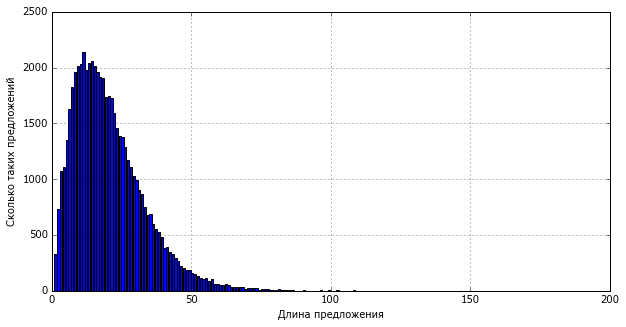

In [647]:
len_sentences = [len(sentence) for sentence in brown_tagged_sents]
len_of_sents = Counter(len_sentences)
counts, len_freqs = zip(*len_of_sents.items())
plt.figure(figsize=(10, 5))
plt.xlabel(u'Длина предложения')
plt.ylabel(u'Сколько таких предложений')
plt.bar(counts, len_freqs)
plt.grid()

Распределение длин предложений в тексте похоже на нормальное с центром в 20, что не вызывает сомнений, так как длинные и короткие предложения трудно представить.

In [635]:
words = [word for sentence in brown_tagged_sents for word, _ in sentence]
tags = [tag for sentence in brown_tagged_sents for _, tag in sentence]

word_freq_dict = Counter(words)
tag_freq_dict = Counter(tags)

In [636]:
words, word_freqs = zip(*word_freq_dict.items())
inds = np.argsort(word_freqs)[::-1]
words = np.array(words)[inds]
word_freqs = np.array(word_freqs)[inds]

tags, tag_freqs = zip(*tag_freq_dict.items())
inds = np.argsort(tag_freqs)[::-1]
tags = np.array(tags)[inds]
tag_freqs = np.array(tag_freqs)[inds]

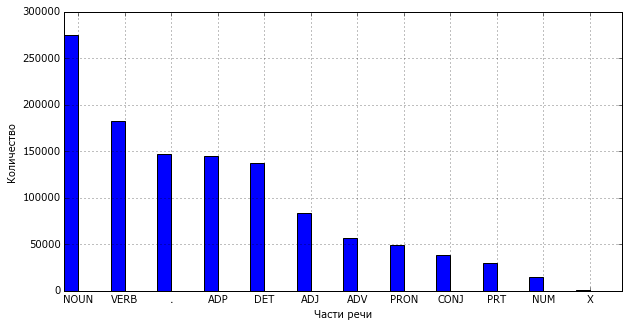

In [637]:
inds = np.arange(len(tags))
bar_width = 0.3
plt.figure(figsize=(10, 5))
plt.bar(inds, tag_freqs, width=0.3)
plt.grid()
plt.xticks(inds + bar_width, tags)
plt.xlabel(u'Части речи')
plt.ylabel(u'Количество')

Видно, что преобладающее большинство тегов -- существительные и глаголы. Здесь также нет сомнений, так как предложения можно построить только на основе существительных и глаголов.

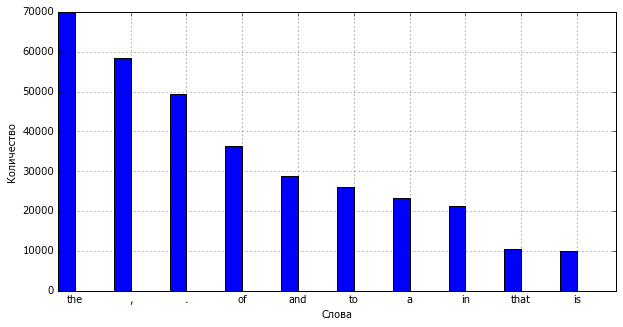

In [638]:
inds = np.arange(len(words))[:10]
bar_width = 0.3
plt.figure(figsize=(10, 5))
plt.bar(inds, word_freqs[:10], width=0.3)
plt.grid()
plt.xticks(inds + bar_width, words[:10])
plt.xlabel(u'Слова')
plt.ylabel(u'Количество')

Большинство "слов" -- это артикли, пунктуация и предлоги, которые невозможно не встретить в английских предложениях. Посмотрим на редко встречаемые слова.

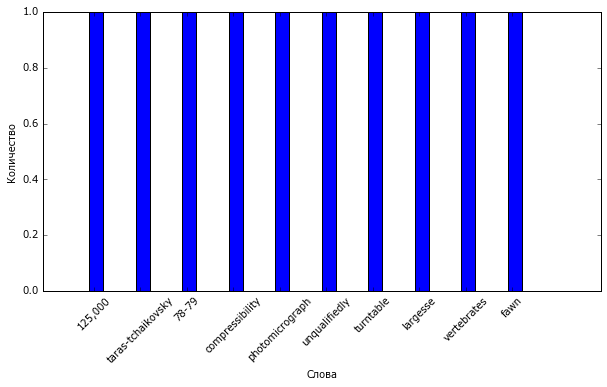

In [639]:
inds = np.arange(len(words))[-10:]
bar_width = 0.1
plt.figure(figsize=(10, 5))
plt.bar(inds, word_freqs[-10:], width=0.3)
plt.xticks(inds + bar_width, words[-10:], rotation=45)
plt.xlabel(u'Слова')
plt.ylabel(u'Количество')

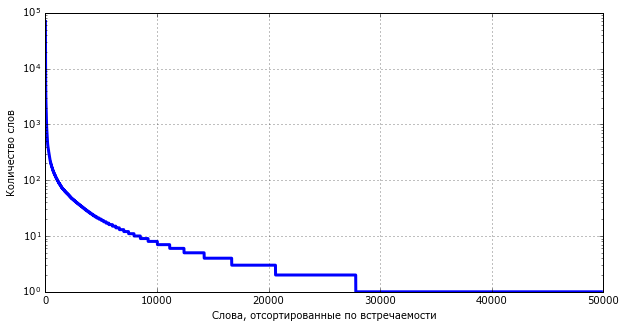

In [646]:
plt.figure(figsize=(10, 5))
plt.plot(word_freqs, lw=3)
plt.grid()
plt.yscale('log')
plt.xlabel(u'Слова, отсортированные по встречаемости')
plt.ylabel(u'Количество слов')

Сформируем необходимые данные для алгоритма Витерби:
$$
p(t_i|t_{i-1}) = \frac{p(t_i, t_{i-1})}{p(t_{i-1})} = \frac{c(t_i, t_{i-1})}{\sum_{t_i}c(t_i, t_{i-1})} \approx \frac{c(t_i, t_{i-1}) + \delta}{\sum_{t_i}c(t_i, t_{i-1}) + \delta V_t}
$$

$$
p(x_i|t_i) = \frac{p(x_i, t_i)}{p(t_i)} = \frac{c(x_i, t_i)}{\sum_{x_i}c(x_i, t_i)} \approx \frac{c(x_i, t_i) + \delta}{\sum_{x_i}c(x_i, t_i) + \delta V_x}
$$

$$
p(t_1) = U\{1, \dots, V_t\}
$$

In [9]:
tag2ind = {
    tag : i for i, tag in enumerate(tag_freq_dict)
}
ind2tag = {
    tag2ind[tag] : tag for tag in tag_freq_dict.keys()
}
word2ind = {
    word : i for i, word in enumerate(word_freq_dict)
}

In [10]:
def calc_viterbi_params(sents, delta=1.0):
    
    word_sents = [[word for word, _ in sentence] for sentence in sents]
    tag_sents = [[tag for _, tag in sentence] for sentence in sents]    
    
    tag_grams = Counter()
    for sentence in tag_sents:
        for i in range(len(sentence)-1):
            tag_grams[tuple(sentence[i:i+2])] += 1
    word_tag_grams = Counter()
    for sentence in sents:
        for word_tag in sentence:
            word_tag_grams[word_tag] += 1
    
    V_tag = len(tag_freq_dict)
    V_word = len(word_freq_dict)
    tag_matr = np.zeros((V_tag, V_tag))# p(t_i|t_{i-1})
    word_tag_matr = np.ones((V_word, V_tag)) * delta #p(x_i|t_i)

    for word_tag, value in word_tag_grams.items():
        word, tag = word_tag
        word_tag_matr[word2ind[word], tag2ind[tag]] += value
    
    for tag_gram, value in tag_grams.items():
        tag1, tag2 = tag_gram # t_{i-1}, t_i
        tag_matr[tag2ind[tag2], tag2ind[tag1]] = value

    for i in range(V_tag):
        word_tag_matr[:, i] = word_tag_matr[:, i] / word_tag_matr[:, i].sum()
        tag_matr[:, i] = (tag_matr[:, i] + delta) / (tag_matr[:, i].sum() + delta * V_tag)

    tag_prob = np.ones(V_tag) / V_tag
    
    return tag_prob, word_tag_matr, tag_matr

In [11]:
tag_prob, word_tag_matr, tag_matr = calc_viterbi_params(train_sents, delta=0.01)

#### 1.2 Алгоритм Витерби для применения модели

Чтобы использовать обученную модель для определения частей речи на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамического программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{T} = \arg \max_{T} p(T|X) = \arg \max_{T} p(X, T) $$

Определим функцию, определяющую максимальную вероятность последовательности, заканчивающейся на $i$-ой позиции в состоянии $k$:

$$\delta(k, i) = \max_{t_1, \dots t_{i-1}} p(x_1, \dots x_i, t_1, \dots t_i=k)$$

Тогда $\max_{k} \delta(k, N)$ - максимальная вероятность всей последовательности. А состояния, на которых эта вероятность достигается - ответ задачи.

Алгоритм Витерби заключается в последовательном пересчете функции $\delta(k, i)$ по формуле:

$$\delta(k, i) = \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$

Аналогично пересчитывается функция, определяющая, на каком состоянии этот максимум достигается:

$$s(k, i) = \arg \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$


На практике это означает заполнение двумерных массивов размерности: (длина последовательности) $\times$ (количество возможных состояний). Когда массивы заполнены, $\arg \max_{k} \delta(k, N)$ говорит о последнем состоянии. Начиная с него можно восстановить все состояния по массиву $s$, делая проход назад.

Осталось уточнить, как стартовать последовательный пересчет (чем заполнить первый столбец массива вероятностей):

$$\delta(k, 1) = p(k) p(x_1|t_1=k)$$

В реализации всё переведено к логарифмам, т.к. произведение большого числа маленьких вероятностей может приводить к вычислительным ошибкам:

$$\delta(k, 1) = \log p(k) + \log p(x_1|t_1=k) $$
$$\delta(k, i) = \max_{m} \big\{ \delta(m, i-1) + \log p(t_i = k|t_{i-1} = m) + \log p(x_i|t_i=k)  \big\}$$


In [12]:
def viterbi_algorithm(pi, A, B, test_sents):
    """
        \pi_i = p(t_1 = i)
        A[i, j] = p(t_k = ind2tag[i]| t_{k-1} = ind2tag[j])
        B[i, j] = p(x_k = ind2word[i] | t_k = ind2tag[j])
    """
    test_tag_sents = []
    for sentence in test_sents:
        N = len(sentence)
        delta = np.zeros((len(pi), N))
        s = np.zeros((len(pi), N), dtype=int)
        delta[:, 0] = np.log(pi) + np.log(B[word2ind[sentence[0]], :])
        for i in range(1, N):
            delta[:, i] = np.max(delta[:, i-1][None, :] + np.log(A), axis=1) + np.log(B[word2ind[sentence[i]], :])
            s[:, i] = np.argmax(delta[:, i-1][None, :] + np.log(A), axis=1)
        ind = np.argmax(delta[:, -1])
        tag_sent = [ind2tag[ind]]
        for i in range(1, N):
            ind = s[ind, -i]
            tag_sent.append(ind2tag[ind])
        test_tag_sents.append(tag_sent[::-1])
    return test_tag_sents

Проверим работу алгоритма на модельных примерах.

- 'he can stay'
- 'a milk can'
- 'i saw a dog'
- 'an old saw'

In [13]:
t = viterbi_algorithm(tag_prob, tag_matr, word_tag_matr, 
    [u'he can stay'.split(),
     u'a milk can'.split(),
     u'i saw a dog'.split(),
     u'an old saw'.split()]
    )

In [14]:
t

[[u'PRON', u'VERB', u'VERB'],
 [u'DET', u'NOUN', u'VERB'],
 [u'PRON', u'VERB', u'DET', u'NOUN'],
 [u'DET', u'ADJ', u'VERB']]

Алгоритм Витерби сработал точно на модельных примерах. Посмотрим на отложенной выборке.

In [15]:
word_test = [[word for word, _ in sentence] for sentence in test_sents]
tag_test = [tag for sentence in test_sents for _, tag in sentence]

In [652]:
%%time
pred_tag = viterbi_algorithm(tag_prob, tag_matr, word_tag_matr, word_test)
pred_tag = [tag for tag_sent in pred_tag for tag in tag_sent]

CPU times: user 2.9 s, sys: 12.1 ms, total: 2.91 s
Wall time: 3.8 s


In [17]:
print "Final accuracy:", (np.array(tag_test) == np.array(pred_tag)).mean()

Final accuracy: 0.953969208249


Довольно неплохое accuracy для задачи с 12 классами. Это, возможно, из-за довольно простой структуры предложений в английском языке и эту структуру удачно удалось словить HMM.

#### 1.3. Готовые POS-теггеры из NLTK

В данном подпункте необходимо сравнить работу HMM с готовыми средставми, доступными в библиотеке NLTK: http://www.nltk.org/api/nltk.tag.html

Кандидаты для сравнения:
- Простейший теггер, который всем словам ставит в соответствие одну и ту же метку
- Основанный на правилах RegexpTagger (правила можно поискать в Интернете или придумать самим)
- N-граммные теггеры (разберитесь и поэкспериментируйте с параметром backoff)
- Теггеры на основе графических моделей (можно взять только Stanford): 
    - HiddenMarkovModelTagger
    - CRFTagger
    - StanfordPOSTagger (потребуется .jar файл теггера и обученная модель (легко находятся в Интернете), чтобы подать на вход конструктору класса)
- BrillTagger, основанный на трансформациях

При проведении экспериментов обращайте внимание на следующие моменты (и отразите их в отчете):
- Какой подход лежит в основе теггера
- На каких данных он обучен (если Вы скачали готовую модель)
- Сколько времени занимает обучение на brown корпусе (если обучаете сами)
- Какая точность получается на контролькой выборке (метод evaluate())

Сформируйте рекоммендиции о том, какую технологию Вы бы использовали, если встретитесь с задачей определения частей речи в будущем.

In [18]:
import nltk
from nltk.tag import DefaultTagger
from nltk.tag import RegexpTagger
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger
from nltk.tag import TrigramTagger
from nltk.tag import  HiddenMarkovModelTagger
from nltk.tag import CRFTagger
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tag import BrillTagger

#### DefaultTagger

In [649]:
%%time
stupid_tagger = DefaultTagger(u'NOUN')
print u"Точность DefaultTagger:", stupid_tagger.evaluate(test_sents)

Точность DefaultTagger: 0.235538594244
CPU times: user 142 ms, sys: 4.01 ms, total: 146 ms
Wall time: 141 ms


Самый простой константный тегер, который для всего выдаёт одно и то же значение. Разумно брать значение константы, как самый часто встречаемый класс в трейне. Можно узнать распределение классов на тесте или подать его более мощному тегеру.

#### RegexpTagger

In [650]:
regexp = [(r'(.*able|.*ing)$', 'ADJ'),       # adjectives
          (r'.*ly$', 'ADV'),                 # adverbs
          (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),  # numbers
          (r'(the|a|an|some)$', 'DET'),      # determiner, article
          (r'.*ed$', 'VERB'),                # verb
          (r'(.*s|.*ness)$', 'NOUN'),        # noun
          (r'[.,;]', '.'),                   # pucntuation
          (r'.*', 'X')                       # other 
          ]

In [651]:
%%time
regexp_tagger = RegexpTagger(regexp, backoff=stupid_tagger)
print u"Точность RegexpTagger:", regexp_tagger.evaluate(test_sents)

Точность RegexpTagger: 0.297453189395
CPU times: user 2.18 s, sys: 44.1 ms, total: 2.22 s
Wall time: 2.18 s


Также простой тегер. Процесса обучения нет. Нужно просто задать регулярные выражения и ответы по ним, то есть, по сути, обучение проводим мы сами. 

#### UnigramTagger

In [21]:
%%time
unigram_tagger = UnigramTagger(train_sents)
print u"Точность UnigramTagger:", unigram_tagger.evaluate(test_sents)

Точность UnigramTagger: 0.932378388269
CPU times: user 2.9 s, sys: 28.7 ms, total: 2.93 s
Wall time: 2.91 s


#### BigramTagger

In [22]:
%%time
bigram_tagger = BigramTagger(train_sents, backoff=unigram_tagger)
print u"Точность BigramTagger:", bigram_tagger.evaluate(test_sents)

Точность BigramTagger: 0.94111752969
CPU times: user 5.71 s, sys: 49.5 ms, total: 5.76 s
Wall time: 5.74 s


#### TrigramTagger

In [23]:
%%time
trigram_tagger = TrigramTagger(train_sents, backoff=bigram_tagger)
print u"Точность TrigramTagger:", trigram_tagger.evaluate(test_sents)

Точность TrigramTagger: 0.940716731579
CPU times: user 8.11 s, sys: 120 ms, total: 8.23 s
Wall time: 8.09 s


Тегеры на основе униграм, биграм, триграм. Backoff -- это тот тегер, к которому обращается текущий, если не было найдено примеров (аналогия с Backoff в сглаживании биграм, триграм). Довольно высокое качество, однако по мере увеличения грамности (из биграмы в триграму) качество уменьшается.

#### StanfordPOSTagger

In [35]:
from nltk.tag import mapping
import os
from nltk.internals import find_jars_within_path

ptb2univer = mapping.tagset_mapping('en-ptb', 'universal')

java_path = "/usr/bin/java"
os.environ['JAVAHOME'] = java_path
path_to_model = "stanford-postagger-2015-12-09/models/english-bidirectional-distsim.tagger"
path_to_jar = "stanford-postagger-2015-12-09/stanford-postagger.jar"

In [36]:
%%time
stanford_tagger = StanfordPOSTagger(path_to_model, path_to_jar)
stanford_dir = stanford_tagger._stanford_jar.rpartition('/')[0]
stanford_jars = find_jars_within_path(stanford_dir)
stanford_tagger._stanford_jar = ':'.join(stanford_jars)
stanford_pred = [
    ptb2univer[pred_tag] for pred_sentence in stanford_tagger.tag_sents(word_test)
    for _, pred_tag in pred_sentence
]
print u"Точность StanfordPOSTagger:", (np.array(tag_test) == np.array(stanford_pred)).mean()

/root/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Точность StanfordPOSTagger: 0.910979254341
CPU times: user 228 ms, sys: 68 ms, total: 296 ms
Wall time: 2min 17s


StanfordPOSTagger -- тегер на основе графических моделей, однако показал значительно плохое качество классификации (по сравнению с HMM). Преимущество: можно получить уже обученный тегер с сайта https://nlp.stanford.edu/software/tagger.shtml

#### CRFTagger

In [32]:
%%time
crf_tagger = CRFTagger()
crf_tagger.train(train_sents, 'model.crf.tagger')
print u"Точность CRFTagger:", crf_tagger.evaluate(test_sents)

Точность CRFTagger: 0.962037448484
CPU times: user 5min 42s, sys: 248 ms, total: 5min 42s
Wall time: 5min 42s


CRFTagger -- также основан на графических моделях. Подробное описание чуть ниже. Имеет очень хорошее качество классификации и обучается не очень долго.

#### BrillTagger

In [26]:
from nltk.tag import brill
brill_tagger = nltk.tag.brill_trainer.BrillTaggerTrainer(bigram_tagger, brill.nltkdemo18plus())

In [30]:
%%time
brill_tagger = brill_tagger.train(train_sents)

CPU times: user 1h 17min 46s, sys: 6.94 s, total: 1h 17min 53s
Wall time: 1h 17min 58s


In [31]:
print u"Точность BrillTagger:", brill_tagger.evaluate(test_sents)

Точность BrillTagger: 0.954701100452


BrillTagger -- тегер на трансформациях. Данный тегер изменяет слово на основе предопределенных правил. Обучается очень долго, однако по качеству не превосходит CRFTagger.

##### Выводы
| Модель | Время обучения | Точность |
|------|------|------|
|   HMM  | 3s |0.954 |
|DefaultTagger| 0 | 0.235|
|RegexpTagger|2s| 0.297|
|Unigram|3s|0.932|
|Bigram|5s|0.941|
|Trigram|8s|0.94|
|CRFTagger|5m42s|**0.962**|
|StanfordPOSTagger|0(уже обучена)|0.91|
|BrillTagger|1h17m|0.954|

Лучше всего использовать CRFTagger.

### 2. Выделение именованных сущностей (NER)



#### 2.1. Генерация признаков для CRF

Выделение именованных сущностей - другая распространенная задача разметки последовательности слов. Чаще всего она решается марковскими моделями максимальной энтропии (MEMM) или условными случайными полями (CRF). При этом основная сложность заключается в генерации  хороших признаков. 

В данном задании требуется придумать и использовать множество признаков для обучения CRF из библиотеки CRFsuite. В этой библиотеке реализована linear-chain CRF с потенциалами двух типов (аналогично HMM):

$$ \psi_{mk}(t_{i-1}, t_{i}) = [t_{i-1} = m] \, [t_{i} = k]; \quad \psi_{jk}(t_{i}, x_i) = [t_{i} = k] \, f_j(x_i)$$


Потенциалы первого типа назвают transition features, они зависят только от биграмм меток. Потенциалы второго типа -- label-observation (node-observation) features; они зависят от метки и признаков наблюдаемого слова (observation features). Несмотря на то, что в формуле явно участвует текущее слово $x_i$, подход остается полностью корректным, когда признаки зависят также от контекста слова (соседних слов). Это следствие того, что CRF является дискриминативной моделью, и наблюдаемые переменные $X$ не моделируются. 


**Указания к заданию:** 
- Загрузите из NLTK обучающие и тестовые датасеты для задачи выделения именованных сущностей CoNLL 2002 shared task на испанском и голландском языках в BIO-нотации (nltk.corpus.conll2002), а так же CoNLL 2000 на английском языке.
- Для обучения CRF модели библиотеке необходимо передать последовательность наблюдаемых признаков $f_j(x_i)$ и меток $y_i$. Ниже приведен весь технический код, который позволит сконцентрироваться только на самом творческом этапе -- генерации признаков.
- Оцените качество приведенного решения. 
- Ваша задача заключается в том, чтобы повысить его. Помимо генерации новых признаков, можно обратить внимание на параметры обучения, в частности, feature.minfreq позволяет отсеивать редкие признаки.  
- При проверке задания будет оцениваться как достигнутое качество, так и разнообразие/оригинальность использованных признаков. Если вы попробовали какие-то признаки, но они не помогли, также включите их в отчет. 
- Если у Вас закончилась фантазия, почитайте обзоры и статьи по теме.


In [617]:
# Let's define very simple example features.
import re

# Бейзлайн
def word2features_base(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word.isupper=%s' % word.isupper(),
        'postag=' + postag,
        # your code here
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
        ])
    else:
        features.append('BOS')
    return features


#Новые фичи
def word2features_extend(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word.isupper=%s' % word.isupper(),
        'word.isupper=%s' % word.isupper(),
        'postag=' + postag,
        'word.istitle=%s' % word.istitle()
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word[-3]=' + word1[-3:],
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.islower=%s' % word1.islower(),
            '-1:word.isalnum=%s' % word1.isalnum(), 
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            '-1:word_digit=%s' % bool(re.search(r'\d', word1)),
        ])
    else:
        features.append('BOS')
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word[-3:]=' + word1[-3:],
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.islower=%s' % word1.islower(),
            '+1:word.isalnum=%s' % word1.isalnum(), 
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1
        ])
    else:
        features.append('EOS')
    return features

def sent2features(sent, base=True):
    if base:
        return [word2features_base(sent, i) for i in range(len(sent))]
    else:
        return [word2features_extend(sent, i)  for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [618]:
# Let's prepare functions for more comfortable work with pycrfsuite.

import pycrfsuite

MODEL_NAME = 'model.crfsuite'

def train(train, base=True):
    X_train = [sent2features(s, base=base) for s in train]
    y_train = [sent2labels(s) for s in train]
    
    trainer = pycrfsuite.Trainer(verbose=False, algorithm='lbfgs')

    trainer.set_params({'c1': 0.3, 'c2': 5*1e-2, 'max_iterations': 50, 'linesearch': 'StrongBacktracking',
                            'max_linesearch':10, 'feature.minfreq': 0.1, 'feature.possible_transitions': True})
    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.train(MODEL_NAME)

def evaluate(test, base=True):
    X_test = [sent2features(s, base=base) for s in test]
    y_test = [sent2labels(s) for s in test]

    tagger = pycrfsuite.Tagger()
    tagger.open(MODEL_NAME)

    y_pred = [tagger.tag(x) for x in X_test]

    true_counter, total_counter = 0.0, 0.0
    for p, t in zip(y_pred, y_test):
        assert len(p) == len(t)
        total_counter += len(p)
        true_counter += sum([str(i) == str(j) for i, j in zip(p, t)])
    return true_counter / total_counter

In [593]:
from nltk.corpus import conll2002, conll2000

In [594]:
conll2002.fileids()

[u'esp.testa',
 u'esp.testb',
 u'esp.train',
 u'ned.testa',
 u'ned.testb',
 u'ned.train']

In [595]:
conll2000.fileids()

['train.txt', 'test.txt']

In [596]:
train_sents_ned = list(conll2002.iob_sents(u'ned.train'))
test_sents_ned = list(conll2002.iob_sents(u'ned.testa'))

train_sents_esp = list(conll2002.iob_sents(u'esp.train'))
test_sents_esp = list(conll2002.iob_sents(u'esp.testa'))

train_sents_eng = list(conll2000.iob_sents('train.txt'))
test_sents_eng = list(conll2000.iob_sents('test.txt'))

##### Данные

In [597]:
all_tags_ned = [tag for train_sent in train_sents_ned for _, _, tag in train_sent]
all_tags_esp = [tag for train_sent in train_sents_esp for _, _, tag in train_sent]
all_tags_eng = [tag for train_sent in train_sents_eng for _, _, tag in train_sent]

In [598]:
tags_ned_freq = Counter(all_tags_ned)
tags_esp_freq = Counter(all_tags_esp)
tags_eng_freq = Counter(all_tags_eng)

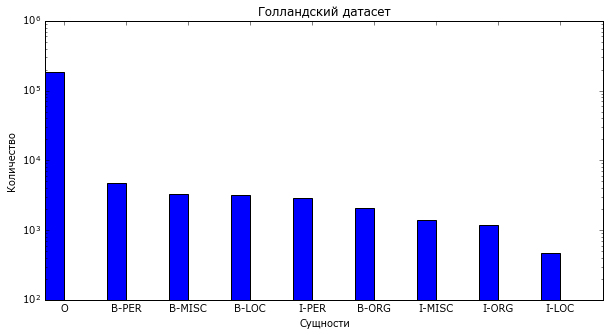

In [599]:
tags, ned_freqs = zip(*tags_ned_freq.items())
inds = np.argsort(ned_freqs)[::-1]
tags = np.array(tags)[inds]
ned_freqs = np.array(ned_freqs)[inds]

inds = np.arange(len(tags))
bar_width = 0.3
plt.figure(figsize=(10, 5))
plt.bar(inds, ned_freqs, width=0.3)
plt.xticks(inds + bar_width, tags)
plt.title(u'Голландский датасет')
plt.xlabel(u'Сущности')
plt.ylabel(u'Количество')
plt.yscale('log')

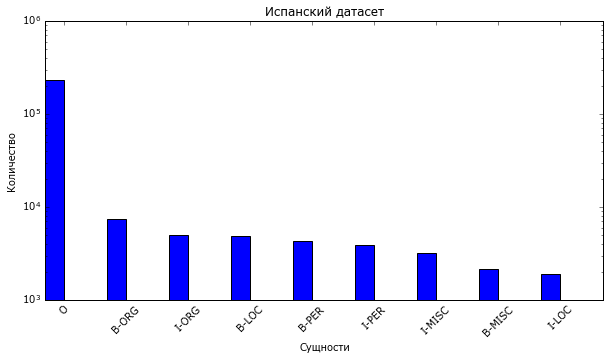

In [600]:
tags, esp_freqs = zip(*tags_esp_freq.items())
inds = np.argsort(esp_freqs)[::-1]
tags = np.array(tags)[inds]
esp_freqs = np.array(esp_freqs)[inds]

inds = np.arange(len(tags))
bar_width = 0.3
plt.figure(figsize=(10, 5))
plt.bar(inds, esp_freqs, width=0.3)
plt.xticks(inds + bar_width, tags, rotation=45)
plt.title(u'Испанский датасет')
plt.xlabel(u'Сущности')
plt.ylabel(u'Количество')
plt.yscale('log')

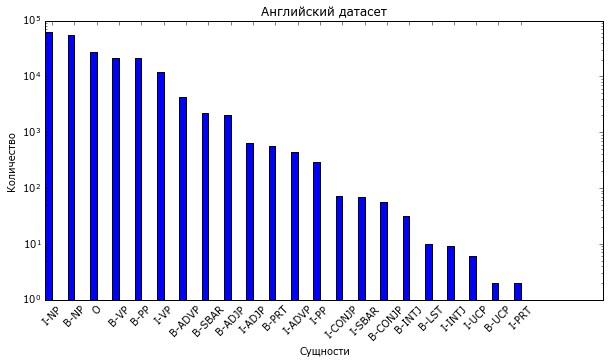

In [601]:
tags, eng_freqs = zip(*tags_eng_freq.items())
inds = np.argsort(eng_freqs)[::-1]
tags = np.array(tags)[inds]
eng_freqs = np.array(eng_freqs)[inds]

inds = np.arange(len(tags))
bar_width = 0.3
plt.figure(figsize=(10, 5))
plt.bar(inds, eng_freqs, width=0.3)
plt.xticks(inds + bar_width, tags, rotation=45)
plt.title(u'Английский датасет')
plt.xlabel(u'Сущности')
plt.ylabel(u'Количество')
plt.yscale('log')

In [619]:
%%time
train(train_sents_ned)
print u"Точность на голландском корпусе (бейзлайн):", evaluate(test_sents_ned)

Точность на голландском корпусе (бейзлайн): 0.950539973996
CPU times: user 12.9 s, sys: 84.1 ms, total: 13 s
Wall time: 12.9 s


In [620]:
%%time
train(train_sents_ned, base=False)
print u"Точность на голландском корпусе (с добавлением фичей):", evaluate(test_sents_ned, base=False)

Точность на голландском корпусе (с добавлением фичей): 0.967150476292
CPU times: user 23.9 s, sys: 208 ms, total: 24.1 s
Wall time: 24.1 s


In [621]:
%%time
train(train_sents_esp)
print u"Точность на испанском корпусе (бейзлайн):", evaluate(test_sents_esp)

Точность на испанском корпусе (бейзлайн): 0.934981010147
CPU times: user 17.4 s, sys: 148 ms, total: 17.6 s
Wall time: 17.5 s


In [622]:
%%time
train(train_sents_esp, base=False)
print u"Точность на испанском корпусе (с добавлением фичей):", evaluate(test_sents_esp, base=False)

Точность на испанском корпусе (с добавлением фичей): 0.953857491072
CPU times: user 30.7 s, sys: 244 ms, total: 30.9 s
Wall time: 30.9 s


In [623]:
%%time
train(train_sents_eng)
print u"Точность на английском корпусе (бейзлайн):", evaluate(test_sents_eng)

Точность на английском корпусе (бейзлайн): 0.951685416974
CPU times: user 29.5 s, sys: 60.1 ms, total: 29.5 s
Wall time: 29.5 s


In [624]:
%%time
train(train_sents_eng, base=False)
print u"Точность на английском корпусе (с добавлением фичей):", evaluate(test_sents_eng, base=False)

Точность на английском корпусе (с добавлением фичей): 0.952424172067
CPU times: user 47.9 s, sys: 312 ms, total: 48.2 s
Wall time: 48.2 s


##### Выводы:
- Добавление дополнительных признаков увеличило качество классификации. Добавил фичи на основе следующего слова (x_{i+1}).
- Также можно было потюнить параметры CRF. Например, в работе использовался метод оптимизации lbfgs и немного изменены параметры c1, c2.

#### 2.2. Stanford NER tagger

Воспользуйтесь StanfordNERTagger для решения задачи NER на тестовых данных CoNLL 2000, только для английского языка (обучать модель не нужно, в Интернете легко найти готовую). Приведите данные в соответствие нужному формату, используйте теггер и оцените качество и скорость работы. Сравните результаты с полученными ранее.

In [323]:
from nltk.tag import StanfordNERTagger
path_to_model = 'stanford-ner-2018-02-27/classifiers/english.conll.4class.distsim.crf.ser.gz'
path_to_jar = "stanford-ner-2018-02-27/stanford-ner.jar"
stanford_ner_tagger = StanfordNERTagger(path_to_model, path_to_jar)

/root/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


'eng2.testa', 'eng2.testb' были скачаны из репозитория 
https://github.com/synalp/NER/tree/master/corpus/CoNLL-2003, распарсены и добавлены в nltk_data/conll2002

In [324]:
test_sents2002 = conll2002.iob_sents(['eng2.testa', 'eng2.testb'])
test_sents_words = [[word for word, _, _ in test_sent] for test_sent in test_sents2002]

In [325]:
%%time
pred_stanford_tag = stanford_ner_tagger.tag_sents(test_sents_words)

CPU times: user 190 ms, sys: 48.1 ms, total: 238 ms
Wall time: 7.95 s


In [326]:
test2stanford = {
    u'B-LOC' : u'LOCATION', 
    u'B-MISC' : u'MISC', 
    u'B-ORG' : u'ORGANIZATION', 
    u'I-LOC' : u'LOCATION', 
    u'I-MISC' : u'MISC', 
    u'I-ORG' : u'ORGANIZATION', 
    u'I-PER' : u'PERSON', 
    u'O' : u'O'
}
pred_stanford_tag = [tag for test_sent in pred_stanford_tag for _, tag in test_sent]
test_tags = [test2stanford[tag] for test_sent in test_sents2002 for _, _, tag in test_sent]

In [327]:
print u"Точность StanfordNERTagger:", (np.array(pred_stanford_tag) == 
                                     np.array(test_tags)).mean()

Точность StanfordNERTagger: 0.981216192726


### Выводы:
- реализован алгоритм Витерби, который показал неплохое качество на брауновском корпусе.
- запущены реализованные в библиотеке тегеры. Лучшим среди них для данной задачи оказался CRFTagger на основе графических моделей.
- решена задача NER с помощью CRF модели. При добавлении новых признаков качество было улучшено.